<!--
Notebook: Mini-Project 1
目的：量化金融练习与小型项目记录
作者：<在此填写>
日期：2025-10-07

注意：这是隐藏注释（HTML 注释），在渲染时不会显示。
TODO：
- [ ] 明确数据来源与下载方式
- [ ] 定义评价指标（如年化收益、夏普比率、最大回撤）
- [ ] 列出实验分组与超参数
- [ ] 在结尾加上局限性与改进方向

小贴士：Markdown 中“# 标题”不是注释；如果需要真正隐藏内容，请使用 <!-- ... -->。
-->



# Mini Project — European vs American Options

This mini project shows the **difference between European and American options**
using a very simple and classic model: the **Cox–Ross–Rubinstein (CRR) binomial tree**.

**You will:**
- Implement pricing for **European** and **American** options (calls & puts).
- See that for **non‑dividend** stocks, **American call = European call**.
- See that **American put ≥ European put** due to early exercise.
- Check that **binomial European** price approaches **Black–Scholes** as steps increase.



## What this project means 

This mini project builds and compares option pricing models to understand when and why American options differ from European options. We use:
- A binomial tree (Cox–Ross–Rubinstein, CRR) to price both European and American options.
- Black–Scholes (BS) as a reference for European options. As the number of binomial steps N increases, CRR converges to BS.

Why it matters:
- American options allow early exercise; European options do not. Understanding the early‑exercise value is fundamental for pricing and risk.
- For non‑dividend equities, an American call has no early‑exercise premium (≈ European call). Puts can have early‑exercise value (American ≥ European).

### Symbols / Parameters 
- S: Spot price of the underlying asset (标的现价)
- K: Strike price (行权价)
- r: Continuously‑compounded risk‑free rate (无风险利率)
- q: Continuous dividend yield or convenience yield (分红/便利收益率)
- σ (sigma): Volatility (波动率)
- T: Time to maturity in years (到期时间，单位年)
- N: Number of binomial steps (二叉树步数)
- Δt = T/N: Time step
- u = e^{σ√Δt}, d = 1/u: Up/Down multipliers
- p = (e^{(r−q)Δt} − d)/(u − d): Risk‑neutral probability
- disc = e^{−rΔt}: One‑step discount factor

### What each section does 
1. Setup: imports and plotting defaults.
2. Black–Scholes: closed‑form price for European options; we use it as a convergence check.
3. CRR Binomial (European & American): core pricer. European uses continuation values; American takes max(continuation, intrinsic).
4. Examples: compute and compare call/put prices across styles (European vs American) and to BS for calls.
5. Convergence plot: show CRR European call → BS as N grows.
6. American put policy grid: visualize at which nodes early exercise is optimal (1 = exercise, 0 = continue).

### How to experiment 
- Change S, K, r, q, σ, T, N in the "Examples" cell to see pricing effects.
- Increase N to improve accuracy (but higher compute cost).
- Set q > 0 to explore dividend effects; American calls can then exceed European calls.




## Setup


In [1]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
np.random.seed(0)



## Black–Scholes 

We only use Black–Scholes to **check** our binomial European prices.


In [2]:

from math import erf

def _phi(x):
    # Standard normal CDF via erf
    return 0.5 * (1.0 + erf(x / math.sqrt(2.0)))

def bs_price(S, K, r, q, sigma, T, is_call=True):
    """
    Black–Scholes European option price.
    """
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        if is_call:
            return max(0.0, S*math.exp(-q*T) - K*math.exp(-r*T))
        else:
            return max(0.0, K*math.exp(-r*T) - S*math.exp(-q*T))
    d1 = (math.log(S/K) + (r - q + 0.5*sigma*sigma)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    if is_call:
        return S*math.exp(-q*T)*_phi(d1) - K*math.exp(-r*T)*_phi(d2)
    else:
        return K*math.exp(-r*T)*_phi(-d2) - S*math.exp(-q*T)*_phi(-d1)



## CRR Binomial Pricing (European & American)

Definitions for $N$ steps with $$\Delta t=T/N:$$
- $$u = e^{\sigma\sqrt{\Delta t}}$$ $$d=1/u$$
- Risk‑neutral prob. $$p = \frac{e^{(r-q)\Delta t} - d}{u-d}$$

**European:** backward induction of **continuation values**
**American:** at each node, take `max(continuation, intrinsic)` to allow early exercise.



> Quick intuition: European pricing uses only discounted expected continuation values under the risk‑neutral measure. American pricing chooses the better of “continue” vs “exercise now” at each node. This difference is what creates the early‑exercise premium when it exists.


In [11]:

def crr_price(S, K, r, q, sigma, T, N, is_call=True, american=False):
    """
    Cox–Ross–Rubinstein (CRR) binomial option price.
    """
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    disc = math.exp(-r * dt)
    p = (math.exp((r - q) * dt) - d) / (u - d)
    if not (0.0 <= p <= 1.0):
        raise ValueError("Arbitrage: adjust parameters so 0 <= p <= 1.")

    # Terminal stock prices
    ST = np.array([S * (u**j) * (d**(N-j)) for j in range(N+1)])

    # Terminal payoffs
    if is_call:
        values = np.maximum(ST - K, 0.0)
    else:
        values = np.maximum(K - ST, 0.0)

    # Backward induction
    for t in range(N-1, -1, -1):
        values = disc * (p * values[1:] + (1-p) * values[:-1])
        if american:
            S_layer = np.array([S * (u**j) * (d**(t-j)) for j in range(t+1)])
            if is_call:
                intrinsic = np.maximum(S_layer - K, 0.0)
            else:
                intrinsic = np.maximum(K - S_layer, 0.0)
            values = np.maximum(values, intrinsic)

    return float(values[0])



## Examples

We use one simple parameter set and compare:
- **Calls (q=0):** American ≈ European.  
- **Puts:** American ≥ European.


In [12]:

# Parameters (easy to edit)
S, K = 100.0, 100.0
r, q = 0.03, 0.00
sigma = 0.20
T = 1.0
N = 200

# Calls (no dividends): American ≈ European
eu_call = crr_price(S, K, r, q, sigma, T, N, is_call=True,  american=False)
am_call = crr_price(S, K, r, q, sigma, T, N, is_call=True,  american=True)
bs_call = bs_price(S, K, r, q, sigma, T, is_call=True)

print(f"European Call (CRR, N={N}): {eu_call:.4f}")
print(f"American  Call (CRR, N={N}): {am_call:.4f}")
print(f"BS Call (reference)       : {bs_call:.4f}")
print("Note: With q=0, early exercise does not help calls, so European ≈ American.")

# Puts: American ≥ European
eu_put = crr_price(S, K, r, q, sigma, T, N, is_call=False, american=False)
am_put = crr_price(S, K, r, q, sigma, T, N, is_call=False, american=True)

print(f"European Put  (CRR, N={N}): {eu_put:.4f}")
print(f"American  Put  (CRR, N={N}): {am_put:.4f}")
print("Early exercise can add value to puts, so American ≥ European.")


European Call (CRR, N=200): 9.4035
American  Call (CRR, N=200): 9.4035
BS Call (reference)       : 9.4134
Note: With q=0, early exercise does not help calls, so European ≈ American.
European Put  (CRR, N=200): 6.4480
American  Put  (CRR, N=200): 6.7382
Early exercise can add value to puts, so American ≥ European.



## Convergence: CRR European → Black–Scholes

For a European **call** with no dividends, the CRR price approaches Black–Scholes as $N$ grows.


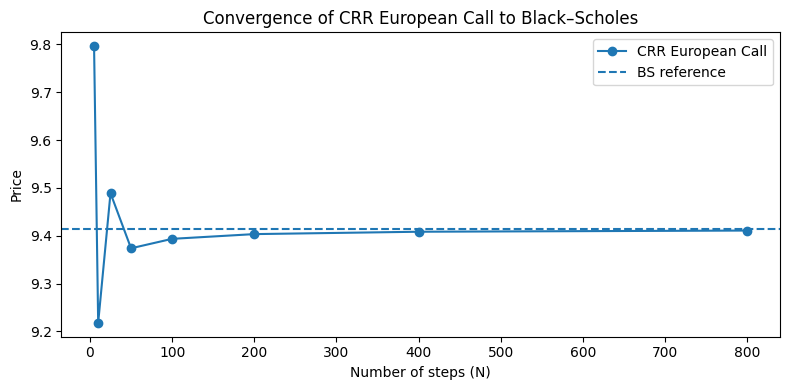

In [13]:

S, K, r, q, sigma, T = 100.0, 100.0, 0.03, 0.0, 0.20, 1.0
bs_ref = bs_price(S, K, r, q, sigma, T, is_call=True)

steps_list = [5, 10, 25, 50, 100, 200, 400, 800]
crr_prices = []
for N in steps_list:
    c = crr_price(S, K, r, q, sigma, T, N, is_call=True, american=False)
    crr_prices.append(c)

plt.figure()
plt.plot(steps_list, crr_prices, marker='o', label="CRR European Call")
plt.axhline(bs_ref, linestyle='--', label="BS reference")
plt.title("Convergence of CRR European Call to Black–Scholes")
plt.xlabel("Number of steps (N)")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()



> What this graph tells:
> - The solid line is the CRR European call price as a function of the number of steps N.
> - The dashed line is the Black–Scholes (BS) reference for the same parameters (S, K, r, q, σ, T).
> - As N increases, CRR converges toward the BS value. Small N can overshoot/undershoot; with N≈200–400 the price is typically within a few cents for these parameters.
> - Binomial convergence often shows a mild odd/even oscillation—don’t worry, it fades as N grows.
> - Practical tip: pick N based on the accuracy/speed trade‑off you need; larger N → better accuracy but slower.



## American Put — a quick look at early exercise

We visualize where **exercise** is optimal in the tree for an American **put**.  
White (1) = exercise, Black (0) = continue (the figure uses default colors).


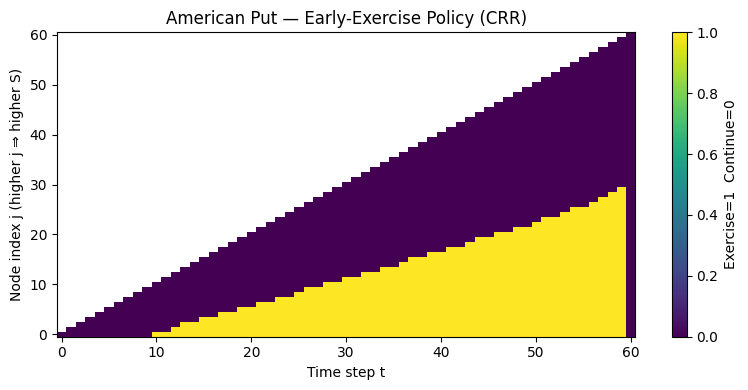

In [14]:

def american_put_policy_grid(S, K, r, q, sigma, T, N):
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    disc = math.exp(-r * dt)
    p = (math.exp((r - q) * dt) - d) / (u - d)

    # Precompute stock prices at nodes
    S_nodes = [[S * (u**j) * (d**(t-j)) for j in range(t+1)] for t in range(N+1)]
    # Terminal payoffs
    V = [max(K - sT, 0.0) for sT in S_nodes[N]]

    policy = [[False]*(t+1) for t in range(N+1)]

    for t in range(N-1, -1, -1):
        V_new = []
        for j in range(t+1):
            cont = disc * (p * V[j+1] + (1-p) * V[j])
            intr = max(K - S_nodes[t][j], 0.0)
            if intr > cont:
                V_new.append(intr)
                policy[t][j] = True
            else:
                V_new.append(cont)
        V = V_new
    return policy

S, K, r, q, sigma, T, N_view = 100.0, 100.0, 0.03, 0.0, 0.20, 1.0, 60
policy = american_put_policy_grid(S, K, r, q, sigma, T, N_view)

# Build a matrix with 1 for exercise, 0 for continue, NaN for padding
grid = np.full((N_view+1, N_view+1), np.nan)
for t in range(N_view+1):
    for j in range(t+1):
        grid[t, j] = 1.0 if policy[t][j] else 0.0

plt.figure()
plt.imshow(grid.T, origin="lower", aspect="auto")
plt.colorbar(label="Exercise=1  Continue=0")
plt.title("American Put — Early-Exercise Policy (CRR)")
plt.xlabel("Time step t")
plt.ylabel("Node index j (higher j ⇒ higher S)")
plt.tight_layout()
plt.show()



> How to read the policy heatmap:
> - Axes: x = time step t (0 → N), y = node index j (higher j ⇒ higher S). The color shows the action: 1 = exercise now (yellow), 0 = continue/hold (purple).
> - The yellow wedge near lower j (lower S) is the region where early exercise of the American put is optimal.
> - The boundary between yellow and purple is the early‑exercise frontier ("free boundary").
> - Intuition: deeper in‑the‑money (low S) and closer to maturity (larger t) make immediate exercise more attractive.
> - Parameter effects (qualitative):
>   • Higher r generally expands the exercise region (money now is more valuable).
>   • Lower σ shrinks continuation value, so exercise becomes optimal more often.
>   • Changing q affects drift under the risk‑neutral measure; explore by editing q to see how the frontier moves.
